## Functions

##### Initialization

In [ ]:
# Base libraries
import numpy as np
import pandas as pd
import math
from itertools import combinations
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import sys
plt.rcParams['figure.figsize'] = (10, 5)

# Convert currencies
#!pip install currencyconverter
#from currency_converter import CurrencyConverter

# Convert strings with commas as thousand separators
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') 

# Convert datatimes
from datetime import datetime

# Read zips
from zipfile import ZipFile

# Dynamic Time Warping
!pip install dtw-python
from dtw import *

# Forecast models
#!pip install -U statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import *
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.feature_extraction import  *
from sklearn.base import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.svm import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.neighbors import *
from imblearn.over_sampling import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
import random

# Scipy
from scipy.stats import *
#from 

# Warnings
import warnings

# To register elapsed time
import time

# Save objects to files
import pickle

def mount_drive_select_path(drive_path = "/content/drive/MyDrive/UA/5º Ano/Tese"):

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)

  # Drive path
  %cd $drive_path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached dtw_python-1.3.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (633 kB)
Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



##### Read data

In [ ]:
def zip_2_dataframe(zip_name, file_name, filetype):
  
  # Open zip file
  zip_file = ZipFile(zip_name, 'r')  

  # Open file
  data_file = zip_file.open(file_name)

  if filetype == "csv":
    df = pd.read_csv(data_file)
  if filetype == "json":
    df = pd.read_json(data_file, lines=True)

  return df

##### Data cleaning

In [ ]:
# Convert a string to datetime data format
def str_2_date(str_date, date_format):
  return datetime.strptime(str(str_date), date_format)

# Replace the last ocurrence of a char in a string by another char
def replace_last_occurrence(str, old_char, new_char):
  
  last_index = str.rfind(old_char)
  if last_index == -1:    # the char wasn't found
    return str
  else:
    return str[:last_index] + new_char + str[last_index+1:]


# Remove commas, dots and currency signs from the prices
def clean_prices(price):

  # Sol peruano (doesn't have decimal cases - thousands are separated with commas)
  if price[0] == "S":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[2:])                              # remove the sign of the currency
    return price
  
  # Dollar (always has decimal cases (i think) - thousands and decimals are both separated by commas)
  if price[0] == "$":
    price = replace_last_occurrence(price, ",", ".")      # replace comma that separates decimals by a dot
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price
  
  # Euro (decimal cases, if there are any, are separated by dots - thousands are separated by commas)
  if price[0] == "€":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price                              
  
  return np.nan


# Convert all prices to a base currency (euro)
def convert_prices_to_euros(row, currency_column, price_column, sol = 0.24, dollar = 1/1.0993):

  currency = row[currency_column]
  price = row[price_column]
  
  if currency in ["€"]:
    return price

  if currency in ["$"]:
    return dollar*price 
  
  if currency in ["S"]:
    return sol*price 


def clean_data(df):

  df = df.copy()
  
  # Convert timestamps' strings to data of date format
  df["timestamp"] = df["timestamp"].apply(str_2_date, args = ('%Y%m%d',))

  # Get type of currency
  df["currency"] = df["price"].str[0]

  # Clean prices (remove commas, dots, and currency signs)
  df["price_clean"] = df["price"].apply(clean_prices)

  # Convert all prices to a base currency (euro)
  df["price_euro"] = df.apply(convert_prices_to_euros, args = ("currency", "price_clean"), axis = 1)

  return df

##### Select time series

In [ ]:
# Select a particular time series based on its ID - ID can be of type: product_id, product_group_id, company_id

def select_time_series(df, id_type, id, price = "price_euro"):

  df = df.copy()

  # Select all rows that have id
  df = df[df[id_type].isin(id)]
  
  # Information about the selected products
  info = {
      "product_id": list(df["product_id"].unique()),
      "product_group_id": list(df["product_group_id"].unique()),
      "company_id": list(df["company_id"].unique()),
      "product": list(df["product"].unique()),
      "country_company": list(df["country_company"].unique()),
      "offer_type": list(df["offer_type"].unique())
      }
  
  return df, info

In [ ]:
def prepare_time_series_univariate(df, price = "price_euro", interpolation_method = "linear"):
  df = df.copy()
  df = df[["timestamp", price]].set_index("timestamp")

  df = fill_miss_vals(df)
  #df = add_stock_info(df)

  df[price] = interpolate(df[price], method = interpolation_method)

  return df

##### Transform data series

In [ ]:
# Apply differences to a time series panda dataframe
def diff_time_series_df(df, diff_order, columns = "all"):
  
  # diff_order - how many times data must be differenced
  # columns - list of the names of columns that will be differenced

  df = df.copy()

  if columns == "all":
    columns = df.columns

  for order in range(diff_order):
    df[columns] = df[columns].diff()
  
  df = df.dropna()

  return df


# Apply differences to a time series panda series
def diff_time_series(df, diff_order):
  
  # diff_order - how many times data must be differenced

  df = df.copy()

  for order in range(diff_order):
    df = df.diff()
  
  df = df.dropna()

  return df

##### Add unique identifiers to data

In [ ]:
def create_id(df, id_name, unique_identifiers, loc = 0):
  df = df.copy()
  df.insert(loc=loc, column=id_name, value=df.set_index(unique_identifiers).index.factorize()[0]+1)
  return df

def add_ids(df):
  df = df.copy()

  df = create_id(df, "product_id", ['company','country','product','offer_type'])
  df = create_id(df, 'product_group_id', ['product','offer_type'])
  df = create_id(df, 'company_id', ['company','country'])
  df.insert(loc=0, column='country_company', value= df.country + " " + df.company)

  return df

##### Order time series by number of changes

In [ ]:
# def get_ordered_number_of_changes(df):
  
#   df_changes = pd.DataFrame({'n_changes' : df.groupby('product_id')['price_clean'].nunique()}).reset_index().sort_values(by = "n_changes", ascending = False)  
#   product_id_ord = df_changes["product_id"].to_numpy()

#   return df_changes, product_id_ord

def get_ordered_number_of_changes(df, id, time, value, interpolation_method):
  
  df = df.copy()
  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  
  df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  n_samples = df.groupby(id)[value].size()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  df["n_changes"] = df.groupby(id)[value].diff()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  df = df.iloc[1:]                                                              # Remove the first row of the dataframe, as it is an NaN
  df = df.groupby(by = [id])["n_changes"].agg(lambda x: x.ne(0).sum())            # Count how many differences are different than zero. This number will correspond to the number of changes in the timeseries
  product_id_ord = df.sort_values(ascending = False).index.to_numpy()           # Get a list of product_ids ordered by number of changes
  
  df = pd.concat([df, n_samples], axis = 1)
  df.columns = ["n_changes", "n_samples"]

  return df, product_id_ord

##### Missing values

In [ ]:
def add_stock_info(df, price = "price_euro"):
  df = df.copy()
  df["days_out_of_stock"] = df[price].isna().astype(int).groupby(df[price].notnull().astype(int).cumsum()).cumsum()
  df["out_of_stock"] = df[price].isna().astype(int)
  return df

# Add the days that are not present in a certain time series
def fill_miss_vals(df, time_column_name = "timestamp"):

  # df - data of a single time series
  # time_column_name - name of the column with the information of timestamps

  df = df.copy()

  idx = pd.date_range(min(df.index), max(df.index))
  df = df.reindex(idx, fill_value=np.nan)
  df.index.name = time_column_name

  return df

# Interpolation
def interpolate(df, method):
  # The interpolate methods that I used were either "linear" (linear interpolation) or "ffill" (repeat last value)
  return df.copy().interpolate(method = method, limit_direction ='forward')  

##### Visualize data

In [ ]:
# Set size of plot
def set_fig_size(size):
  plt.rcParams['figure.figsize'] = size

# Plot the time series of individual products
def show_time_series_product(df, info, price, fig_size = (10, 5)):
  
  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = fig_size
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o')
  
  if len(product_id) == 1:
    ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
    print("Number of samples: ", len(df))

# Plot the time series of all products that belong to a certain group
def show_time_series_product_group(df, info, price,fig_size = (10, 5)):

  df = df.copy()

  plt.rcParams['figure.figsize'] = fig_size
  ax = sns.lineplot(x="timestamp", y=price, hue = "country_company", data=df, marker = 'o')
  ax.set_title(info["product"][0] + " - " + info["offer_type"][0]);

# Plot the time series that belong to a certain company from a certain country
def show_time_series_country_company(df, info, price, fig_size = (10, 5)):

  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = fig_size
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o', legend = False)
  ax.set_title(info["country_company"][0]);


def show_time_series(df, id_type, info, price = "price_euro", fig_size = (10, 5)):

  df = df.copy()
  
  if id_type == "product_id":
    show_time_series_product(df, info, price, fig_size)
  if id_type == "product_group_id":
    show_time_series_product_group(df, info, price, fig_size)
  if id_type == "company_id":
    show_time_series_country_company(df, info, price, fig_size)

##### Performance Metrics

In [ ]:
def get_nmse(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))

  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  nmse = 20*np.log10(np.sqrt(sum((y_obs-y_pred)**2)/sum(y_obs**2)))

  return nmse[0]

In [ ]:
def get_mape(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))
  
  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  n = len(y_obs)
  mape = 1/n*sum(abs((y_obs-y_pred)/y_obs))

  return mape[0]

##### Test stationarity

In [ ]:
def adf_test_results(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput.round(4))


def kpss_test_results(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


def adf_test(timeseries, p_value_max):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    dfoutput["is_stationary"] = (dfoutput.loc["p-value"] < p_value_max)

    return dfoutput

def kpss_test(timeseries, p_value_max):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3],
        index=[
               "Test Statistic",
               "p-value",
               "Lags Used"
               ]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    
    kpss_output["is_stationary"] = (kpss_output.loc["p-value"] > p_value_max)

    return kpss_output


def test_stationarity(timeseries, stationary_tests, p_values_max):
  
  is_stationary = []
  p_values = []
  test_results = []

  for stationary_test, p_value_max in zip(stationary_tests, p_values_max):
    test_result = stationary_test(timeseries, p_value_max)
    is_stationary.append(test_result.loc['is_stationary'])
    p_values.append(test_result.loc['p-value'])
    test_results.append(test_result)

  print("P-Values: ", p_values)

  is_overall_stationary = all(is_stationary)
  if is_overall_stationary:
    print("The timeseries is stationary.")
  else:
    print("Can't confirm the series is stationary.")

  return p_values, test_results, is_stationary, is_overall_stationary

##### Linear models

In [ ]:
def get_lags(timeseries, diff_order, nlags = 40, alpha = 0.05):
  
  timeseries_diff = diff_time_series(timeseries, diff_order)
  acf_coeff,  acf_confint  = acf(timeseries_diff, nlags=nlags, alpha = alpha)
  pacf_coeff, pacf_confint = pacf(timeseries_diff, nlags=nlags, alpha = alpha)

  acf_lags  = tuple(((acf_coeff  > acf_confint[:,1]-acf_coeff)   | (acf_coeff  < acf_confint[:,0]-acf_coeff)).astype(int))
  pacf_lags = tuple(((pacf_coeff > pacf_confint[:,1]-pacf_coeff) | (pacf_coeff < pacf_confint[:,0]-pacf_coeff)).astype(int))

  return acf_lags, pacf_lags

In [ ]:
def plot_results(title, obs, pred, confint, fig_size):
    
    # Graph
    fig, ax = plt.subplots(figsize=(fig_size))
    ax.set(title=title, xlabel='Date', ylabel='Price/€')

    # Plot data points
    obs.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
    ci = confint
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    legend = ax.legend(loc='lower right')
    ax.set_ylim([min(obs)-100, max(obs)+100])

##### Naive models

In [ ]:
class EXPONENTIAL_SMOOTHING:
  def __init__(self):
    pass

  def get_prediction(self, data, smoothing_level):
    
    self.data = data.copy()
    self.beg = 11

    # Series to store one-step-ahead predictions
    self.pred = self.data.iloc[self.beg:].copy()
  
    # Total number of observed samples
    end = len(self.data)

    for i in range(self.beg, end):
      self.pred.iloc[i-self.beg] = SimpleExpSmoothing(self.data.iloc[:i-1], initialization_method="heuristic").fit(smoothing_level=smoothing_level, optimized=False).forecast()

    return self.pred

  def get_metric(self, metric):
    return metric(self.data.iloc[self.beg:], self.pred)

  def plot_results(self):

    fig, ax = plt.subplots(figsize=(10,5))
    ax.set(title=info["product"][0] + " - Exponential Smoothing Prediction", xlabel='Date', ylabel='Price/€')

    # Plot data points
    self.data.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    self.pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')

    legend = ax.legend(loc='lower right')

##### Characteristics of timeseries

In [ ]:
def get_variance(series):
  return np.sum((series - np.mean(series))**2)/len(series)

##### Convert data to features

In [ ]:
def series_to_supervised(data, n_in=2, n_out=1, dropnan=True):
	
  """
  Frame a time series as a supervised learning dataset.
  Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
  Returns:
    Pandas DataFrame of series framed for supervised learning.
  """

  data = list(data)
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

# Notebook: Identify reactivity

- **Goal**: implementation of a simple model to detect reactivity and do a multivariate analysis of the time series

In [ ]:
mount_drive_select_path()

Mounted at /content/drive
/content/drive/MyDrive/UA/5º Ano/Tese


### Get data

#### Read data

In [ ]:
#zip_name = "data/catalog_sample.zip"
#file_name = "catalog_sample.json"
#filetype = "json"
#df_og = zip_2_dataframe(zip_name, file_name, filetype)
df_og = pd.read_pickle("df_og")

#### Clean data and add unique identifiers to products, product groups and companies

In [ ]:
#df = clean_data(df_og.copy())
#df = add_ids(df)
df = pd.read_pickle("df_clean")

In [ ]:
df

#### Interpolate data

In [ ]:
id = "product_id"
value = "price_euro"
time = "timestamp"
interpolation_method = "ffill"

#df_inter = df[[id, value, time]].sort_values([id, time])                         
#df_inter = df_inter.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})
#df_inter.to_pickle("df_inter_fill")
df_inter = pd.read_pickle("df_inter_fill")

#### Order products by number of changes in time series

In [ ]:
# df_changes_linear, product_id_ord_linear = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "linear")
# df_changes_fill, product_id_ord_fill = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "ffill")

# counts = []
# for i in range(min(df_changes_fill["n_changes"]), max(df_changes_fill["n_changes"])):
#   counts.append(len(df_changes_fill["n_changes"][df_changes_fill["n_changes"] > i]))

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(counts)
# #ax.set_yscale('log')
# plt.title("Nº of examples that have more than a certain number of changes");

In [ ]:
df_changes_linear = pd.read_pickle("df_changes_linear")
df_changes_fill = pd.read_pickle("df_changes_fill")
product_id_ord_linear = np.load("product_id_ord_linear.npy")
product_id_ord_fill = np.load("product_id_ord_fill.npy")

### Visualize data

#### Visualize time series

In [ ]:
product_id = [product_id_ord_fill[800]]
df_product, info = select_time_series(df, "product_id", product_id)

product_group_id = info["product_group_id"]
company_id = info["company_id"]

Number of samples:  327


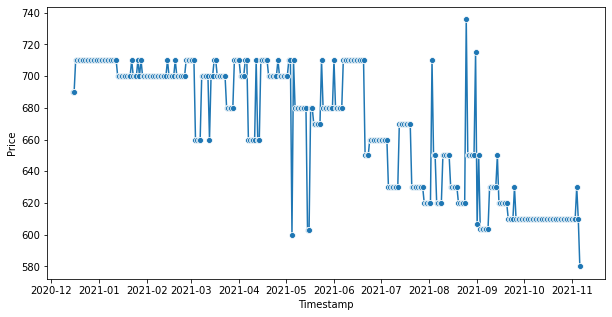

In [ ]:
product_id = [product_id_ord_fill[11]]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")
plt.rcParams['figure.figsize'] = (10, 5)
ax = sns.lineplot(x="timestamp", y="price_euro", data=df_product, marker = 'o').set(xlabel='Timestamp', ylabel='Price')
if len(product_id) == 1:
  #ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
  print("Number of samples: ", len(df_product))
#ax.figure.savefig("Dissertação/Chapters/Imagens/data_two_changes_timeseries.png")

Number of samples:  133


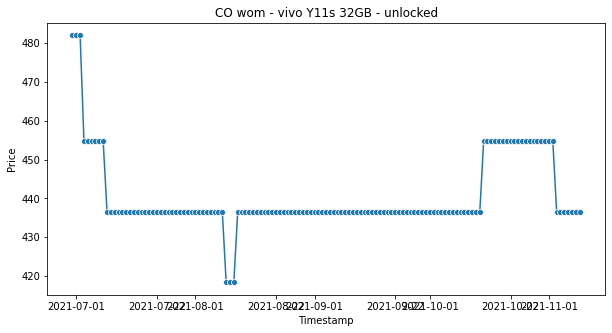

In [ ]:
product_id = [product_id_ord_fill[1000]]
#product_id = [1124]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")

plt.rcParams['figure.figsize'] = (10, 5)
ax = sns.lineplot(x="timestamp", y="price_euro", data=df_product, marker = 'o')
ax.set(xlabel='Timestamp', ylabel='Price')

if len(product_id) == 1:
  ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
  print("Number of samples: ", len(df_product))

#ax.figure.savefig("Dissertação/Chapters/Imagens/data_two_changes_timeseries.png")

In [ ]:
show_time_series(df_product, "product_id", info)

KeyError: ignored

In [ ]:
df_product_group, info = select_time_series(df, "product_group_id", product_group_id)
show_time_series(df_product_group, "product_group_id", info)

In [ ]:
#product_id = [product_id_ord_fill[800]]
product_id = 1124

df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")

diff_order = 1
df_diff = diff_time_series_df(df_product, diff_order, columns = "price_euro")

# Difference
set_fig_size((5, 5))
sns_line = sns.lineplot(x = "timestamp", y = "price_euro", data = df_diff, marker = 'o')
sns_line.set_title("Differencing Order: " + str(diff_order))

### Multivariate analysis and approaches to identify reactivty (cross-correlation and DTW)

###### Find lagged series

In [ ]:
#df_ref = pd.read_pickle("df_ref_7")[["price_euro", "diff", "states", "out_of_stock", 'product', 'country_company', 'country', 'company']].reset_index()
#join_info = df[["product_group_id", "company_id", "offer_type", "product_id"]].drop_duplicates()
#df_all = pd.merge(df_ref, join_info, how = "left", on = "product_id").set_index(["product_id", "timestamp"])
#df_all.to_pickle("df_all")
df_all = pd.read_pickle("df_all")

In [ ]:
# Select country
i = 2
country = df_all.country.unique()[i]
df_country = df_all[df_all.country == country]
print(country)

PT


###### Compare companies with eachother

In [ ]:
# Select product
i = 2
list_product_group = df_country.reset_index().drop_duplicates(subset='product_id', keep='first').groupby(by = ["product", "offer_type", "product_group_id"]).size().sort_values(ascending = False).index.get_level_values(2)
df_country_product_group = df_country[df_country.product_group_id == list_product_group[i]]

# Add min price
df_min = df_country_product_group.groupby(by = "timestamp").min().reset_index()
df_min["product_id"] = "min"
df_min["company"] = "min"

# Add min price
df_max = df_country_product_group.groupby(by = "timestamp").max().reset_index()
df_max["product_id"] = "max"
df_max["company"] = "max"

df_country_product_group = pd.concat([df_country_product_group.reset_index(), df_min, df_max]).set_index(["product_id", "timestamp"])

In [ ]:
# Compare two time series
company_1 = 3
company_2 = 4

companies = df_country_product_group.company.unique()
choose_companies = [companies[company_1], companies[company_2]]

tmp = df_country_product_group[df_country_product_group.company.isin(choose_companies)]

set_fig_size((10, 5))
companies = df_country_product_group.company.unique()sns.lineplot(x = "timestamp", y = "price_euro", hue = "company", data=tmp, marker = 'o')

SyntaxError: ignored

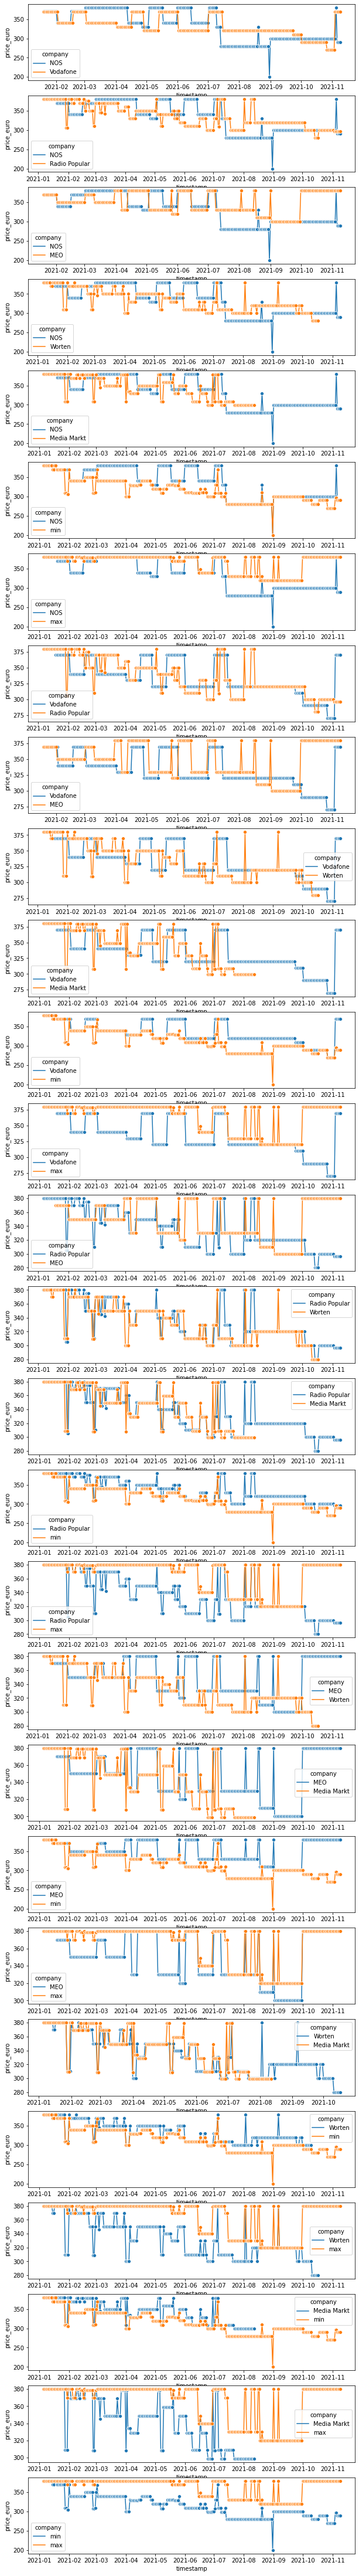

In [ ]:
companies = df_country_product_group.company.unique()
n_companies = len(companies)
ax_count = 0
n_subplots = sum(range(n_companies))

set_fig_size((10, n_companies*10))
fig, ax = plt.subplots(n_subplots, 1)

for i in range(n_companies):
  for j in range(i+1, n_companies):
    
    company_1 = i
    company_2 = j

    companies = df_country_product_group.company.unique()
    choose_companies = [companies[company_1], companies[company_2]]

    tmp = df_country_product_group[df_country_product_group.company.isin(choose_companies)]

    sns.lineplot(x = "timestamp", y = "price_euro", hue = "company", data=tmp, marker = 'o', ax = ax[ax_count])
    ax_count = ax_count + 1

###### Analyse one company

In [ ]:
min_n_samples = 60
df_country_flt = df_country.groupby("product_id").filter(lambda x: len(x) > min_n_samples)
df_country_flt = df_country_flt.groupby(["product", "offer_type"]).filter(lambda x: len(x["company"].unique()) > 1)

In [ ]:
print("Filtered: ", len(df_country_flt.index.get_level_values(0).unique()))
print("Not filtered : ", len(df_country.index.get_level_values(0).unique()))

Filtered:  323
Not filtered :  483


###### Show pairs of time series with constant company for each column

In [ ]:
companies = df_country_flt.company.unique()
n_companies = len(companies)

products = df_country_flt.index.get_level_values(0).unique()
n_products = len(products)

n_companies_1 = 3

ax_count = 0
n_subplots = 150

set_fig_size((10*n_companies_1, n_subplots*5))
fig, ax = plt.subplots(n_subplots, n_companies_1)

for company_1 in range(n_companies_1):
  
  ax_count = 0

  for company_2 in range(company_1, n_companies):

    if ax_count == n_subplots:
      break

    if company_1 != company_2:

      choose_companies = [companies[company_1], companies[company_2]]
      tmp = df_country_flt[df_country_flt.company.isin(choose_companies)]

      products = tmp.product_group_id.unique()
      n_products = len(products)

      for product in range(n_products):
        
        if ax_count == n_subplots:
          break

        tmp_product = tmp[tmp.product_group_id == products[product]]    

        if len(tmp_product.company.unique()) == 2:
          sns.lineplot(x = "timestamp", y = "price_euro", hue = "company", data=tmp_product, marker = 'o', ax = ax[ax_count, company_1])
          ax_count = ax_count + 1

Output hidden; open in https://colab.research.google.com to view.

###### Compare time series to min and max value of price

In [ ]:
def get_min_max_time_series(df, types = ["min", "max"], labels = ["min", "max"]):

  df_types = []
  for type_select, label in zip(types, labels):
    if type_select == "min":
      df_min = df.copy()
      df_min = df_min.loc[df_min.groupby(by = ["product", "offer_type", "timestamp"]).price_euro.idxmin()].reset_index()
      df_min[["company", "product_id"]] = label
      df_types.append(df_min)
    elif type_select == "max":
      df_max = df.copy()
      df_max = df_max.loc[df_max.groupby(by = ["product", "offer_type", "timestamp"]).price_euro.idxmax()].reset_index()
      df_max[["company", "product_id"]] = label
      df_types.append(df_max)

  return df_types

#df_country_min_max = get_min_max_time_series(df_country, types = ["min", "max"], labels = ["min", "max"])
#df_country_min_max = pd.concat([df_country.reset_index()] + df_country_min_max).set_index(["product_id", "timestamp"])

In [ ]:
# Add min and max price ignoring one company at a time
companies = list(df_country_flt.company.unique())
df_min_max = []
print(companies)

for company in companies:
  print(company)
  companies_tmp = companies.copy()
  companies_tmp.remove(company)
  df_country_tmp = df_country_flt[df_country_flt.company.isin(companies_tmp)].copy()
  df_min_max = df_min_max + get_min_max_time_series(df_country_tmp, types = ["min", "max"], labels = ["min_" + company, "max_" + company])

#df_just_min_max = get_min_max_time_series(df_country_flt, types = ["min", "max"], labels = ["min", "max"])
#df_country_min_max = pd.concat([df_country_flt.reset_index()] + df_min_max + df_just_min_max).set_index(["product_id", "timestamp"])
#df_country_min_max.to_pickle("df_country_min_max")
df_country_min_max = pd.read_pickle("df_country_min_max")

['Media Markt', 'MEO', 'Worten', 'Vodafone', 'Radio Popular', 'NOS']
Media Markt
MEO
Worten
Vodafone
Radio Popular
NOS


In [ ]:
df_country_min_max.company.unique()

array(['Media Markt', 'MEO', 'Worten', 'Vodafone', 'Radio Popular', 'NOS',
       'min_Media Markt', 'max_Media Markt', 'min_MEO', 'max_MEO',
       'min_Worten', 'max_Worten', 'min_Vodafone', 'max_Vodafone',
       'min_Radio Popular', 'max_Radio Popular', 'min_NOS', 'max_NOS',
       'min', 'max'], dtype=object)

######Show pairs of time series where one of them is always the min and max price of that product in the market

In [ ]:
companies = df_country_flt.company.unique()
companies_min_max = df_country_min_max.company.unique()[len(companies):]

n_companies = len(companies)
n_companies_1 = 3

ax_count = 0
n_subplots = 150

set_fig_size((10*n_companies_1, n_subplots*5))
fig, ax = plt.subplots(n_subplots, n_companies_1)

for company_1 in range(n_companies_1):
  
  ax_count = 0

  choose_companies = [companies[company_1]] + list(companies_min_max[2*company_1 : 2*company_1 + 2])
  print(choose_companies)
  tmp = df_country_min_max[df_country_min_max.company.isin(choose_companies)]

  products = tmp.product_group_id.unique()
  n_products = len(products)

  for product in range(n_products):
    if ax_count == n_subplots:
      break
    
    tmp_product = tmp[tmp.product_group_id == products[product]]    

    if len(tmp_product.company.unique()) == 3:
      sns.lineplot(x = "timestamp", y = "price_euro", hue = "company", data=tmp_product, marker = 'o', ax = ax[ax_count, company_1]).set_title(products[product])
      ax_count = ax_count + 1

Output hidden; open in https://colab.research.google.com to view.

###### Compare groups of products

In [ ]:
df_country_min_max = pd.read_pickle("df_country_min_max")
df_country_min_max

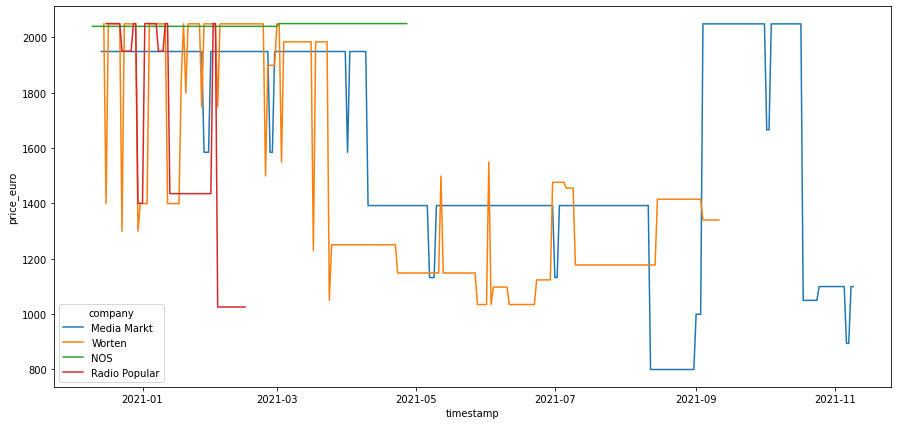

In [ ]:
product_group_id_list = df_country.product_group_id.unique()
df_sel = df_country[df_country.product_group_id == product_group_id_list[29]]
set_fig_size((15,7))
sns.lineplot(data = df_sel, x = "timestamp", y = "price_euro", hue = "company")

###### Cross correlation

In [ ]:
def round_to_multiple(number, multiple):
  return multiple * round(number / multiple)

# Get cross-correlation
def get_corr_1(x1, x2):
  if len(x1) != len(x2):
    print(len(x1), len(x2))
  return np.corrcoef(x1, x2)[0,1]

# Get variance of how many changes there are between time series that are different. The bigger the variance the more non similar the two timeseries are. In this type of evalution the absolute value of timeseries matters, as it must be the same
def get_corr_2(x1, x2):
  return np.var(x1-x2)

def get_corr_3(x1, x2):
  # fazer dynamic time warping aqui

  #como os pontos iniciais e finais são fixos, caso não haja correspondência entre eles, a distância do dataset aumenta sempre muito. 
  #Pode-se descartar esses pontos iniciais e finais e considerar só o intervalo do meio da série, 
  #ou pode-se calcular a distância sem que se façam time warping e caso haja uma diminuição significativa da distância após time warmping, bom sinal
  return 0

# Get lagged correlations between two vectors. Select the time interval that must be sliced. This interval will be chosen from the middle of the timeseries. It should be an even number so it can be divided by 2 and remain an integer.
def get_lagged_corr(x1, x2, time_interval):

  x1_move_corr = []
  x2_move_corr = []

  time_interval_half = int(time_interval/2)
  x1_slide = x1[time_interval_half:-time_interval_half].to_numpy()
  x2_slide = x2[time_interval_half:-time_interval_half].to_numpy()

  x1_slide_corr = []
  x2_slide_corr = []
  for lag in range(time_interval):
    x1_slide_corr.append(get_corr_1(x1_slide, x2[lag:lag+time_interval]))
    x2_slide_corr.append(get_corr_1(x2_slide, x1[lag:lag+time_interval]))

  x1_slide_corr = pd.Series(data = x1_slide_corr, index = range(-15,15))
  x2_slide_corr = pd.Series(data = x2_slide_corr, index = range(-15,15))
  
  return x1_slide_corr, x2_slide_corr

# Divide a pair of timeseries in smaller intervals and get the lagged correlations between those intervals
def get_timeseries_similarity(df_companies, time_interval):

  df_companies = df_companies.copy().reset_index()

  # Get timeseries characteristics
  companies = list(df_companies.company.unique())
  product_ids = list(df_companies.product_id.unique())
  product_group_id = list(df_companies.product_group_id.unique())
  product = list(df_companies["product"].unique())

  if (len(product) != 1) | (len(product_group_id) != 1):
    print("Erorr: More than one product or product_group.")
  
  company_1 = companies[0]
  company_2 = companies[1]
  product_id_1 = product_ids[0]
  product_id_2 = product_ids[1]
  product_group_id = product_group_id[0]
  product = product[0]
  
  # Align time series and make their length multiple of time interval
  x1 = df_companies[df_companies.company == company_1].set_index("timestamp")["price_euro"]
  x2 = df_companies[df_companies.company == company_2].set_index("timestamp")["price_euro"]
  x1_aligned, x2_aligned = x1.align(x2, join = "inner")

  if len(x1) == 0:
    print("The timeseries have no intersection.")

  # Get correlations for each timeseries
  corr_dicts = []
  for i in range(min(len(x1_aligned), len(x2_aligned)) - time_interval*2):
    
    x1_slide = x1_aligned[i:i+time_interval*2]
    x2_slide = x2_aligned[i:i+time_interval*2]
      
    x1_slide_corr, x2_slide_corr = get_lagged_corr(x1_slide, x2_slide, time_interval)
    
    # Save correlation information. Each one of these dicts will be a line in a dataframe
    corr = {"product_group_id" : product_group_id,
            "product" : product,
            "company_1" : company_1,
            "company_2" : company_2,
            "product_id_1" : product_id_1,
            "product_id_2" : product_id_2,
            "x1_slide" : x1_slide,
            "x2_slide" : x2_slide,
            "x1_slide_corr" : x1_slide_corr,
            "x2_slide_corr" : x2_slide_corr}
  
    corr_dicts.append(corr)
    
  # Save timeseries that were correlated  
  pairs = {"product_group_id" : product_group_id,
            "product" : product,
            "company_1" : company_1,
            "company_2" : company_2,
            "product_id_1" : product_id_1,
            "product_id_2" : product_id_2,
            "x1" : x1,
            "x2" : x2,
            "x1_aligned" : x1_aligned,
            "x2_aligned" : x2_aligned}
           
  return pairs, corr_dicts


# Get all timeseries from a country, group timeseries by product and offer_type, pair each timeseries inside those groups and get the correlations for each pair of timeseries 
def get_df_timeseries_similarity(df, time_interval, max_number_product_groups):

  df = df.copy()

  # Lists to keep the pairs of timeseries and the correlations between each pair
  pairs_list = []
  corr_list = []

  # Get all product_groups inside the given dataframe
  product_groups = list(df.product_group_id.unique())
  print("Product groups : ", product_groups)
  print("# Product groups : ", len(product_groups))

  # Iterate over each product_group and pair timeseries
  for product_group in product_groups:

    if max_number_product_groups != None:
      if product_group == product_groups[max_number_product_groups]:
        break

    print("Product group : ",  product_group)
    
    df_product_group = df[df.product_group_id == product_group]
    companies = list(df_product_group.company.unique())
    companies_combinations = filter_min_max_combinations(list(combinations(companies, 2)))

    # Select a pair of companies from that product_group
    for company in companies_combinations:
    
      print(company)

      df_product_group_companies = df_product_group[df_product_group.company.isin(company)]
      pairs, corr = get_timeseries_similarity(df_product_group_companies, time_interval)
      
      pairs_list.append(pairs)
      corr_list.append(corr) 

  df_pairs = pd.DataFrame(pairs_list)
  df_corr = pd.concat(list(map(pd.DataFrame, corr_list)))

  return df_pairs, df_corr

def filter_min_max_combinations(companies):
  
  filter = []
  for company_group in companies:
    c_1 = company_group[0]
    c_2 = company_group[1]

    c_1_has_min_max = (("min_" in c_1) | ("max_" in c_1))
    c_1_is_min_max = ((c_1 == "min") | (c_1 == "max"))
    c_2_has_min_max = (("min_" in c_2) | ("max_" in c_2))
    c_2_is_min_max = ((c_2 == "min") | (c_2 == "max"))

    if ((c_1_has_min_max | c_1_is_min_max) & (c_2_has_min_max | c_2_is_min_max)):
      flt = False
    elif ((c_1_has_min_max & (c_2 not in c_1)) | (c_2_has_min_max & (c_1 not in c_2))):
      flt = False
    else:
      flt = True
    
    filter.append(flt)

  return list(compress(companies, filter))

In [ ]:
df_country_min_max = pd.read_pickle("df_country_min_max")

time_interval = 30
max_number_product_groups = None

df_pairs, df_corr = get_df_timeseries_similarity(df_country_min_max, time_interval, max_number_product_groups)

#df_pairs.to_pickle("df_pairs_PT")
#df_corr.to_pickle("df_corr_PT_minNSamples60_timeInterval30")

Product groups :  [8, 23, 46, 87, 96, 99, 120, 126, 136, 140, 153, 155, 171, 179, 182, 189, 191, 199, 212, 245, 278, 282, 315, 327, 330, 332, 335, 345, 347, 349, 360, 370, 381, 405, 413, 414, 417, 421, 424, 427, 434, 435, 437, 441, 450, 467, 468, 478, 529, 551, 554, 557, 563, 574, 583, 590, 594, 601, 603, 604, 607, 608, 610, 614, 616, 618, 621, 641, 670, 674, 676, 764, 775, 777, 784, 794, 797, 800, 838, 870, 888, 891, 910, 913, 921, 923, 932, 940]
# Product groups :  88
Product group :  8
('Media Markt', 'MEO')


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


('Media Markt', 'Worten')
('Media Markt', 'Vodafone')
('Media Markt', 'Radio Popular')
('Media Markt', 'NOS')
('Media Markt', 'min_Media Markt')
('Media Markt', 'max_Media Markt')
('Media Markt', 'min')
('Media Markt', 'max')
('MEO', 'Worten')
('MEO', 'Vodafone')
('MEO', 'Radio Popular')
('MEO', 'NOS')
('MEO', 'min_MEO')
('MEO', 'max_MEO')
('MEO', 'min')
('MEO', 'max')
('Worten', 'Vodafone')
('Worten', 'Radio Popular')
('Worten', 'NOS')
('Worten', 'min_Worten')
('Worten', 'max_Worten')
('Worten', 'min')
('Worten', 'max')
('Vodafone', 'Radio Popular')
('Vodafone', 'NOS')
('Vodafone', 'min_Vodafone')
('Vodafone', 'max_Vodafone')
('Vodafone', 'min')
('Vodafone', 'max')
('Radio Popular', 'NOS')
('Radio Popular', 'min_Radio Popular')
('Radio Popular', 'max_Radio Popular')
('Radio Popular', 'min')
('Radio Popular', 'max')
('NOS', 'min_NOS')
('NOS', 'max_NOS')
('NOS', 'min')
('NOS', 'max')
Product group :  23
('NOS', 'Vodafone')
('NOS', 'MEO')
('NOS', 'Media Markt')
('NOS', 'Radio Popular')
(

###### Dynamic Time Warping

In [ ]:
df_pairs = pd.read_pickle("df_pairs_PT")
df_corr = pd.read_pickle("df_corr_PT_minNSamples60_timeInterval30")

In [ ]:
df_pairs

The companies that were found to have the plots with most correlations were (this was obtained after analysing the plots from "Show pairs of time series with constant company for each column". Not all pairs of plots are shown in this cell, so there may be other groups of companies that have very correlated series):
- Media Markt and Radio Popular
- Radio Popular and Worten
- Media Markt and Worten

In [ ]:
choose_companies_1 = ((df_pairs.company_1 == "Media Markt")   & (df_pairs.company_2 == "Radio Popular")) | ((df_pairs.company_1 == "Radio Popular") & (df_pairs.company_2 == "Media Markt"))
choose_companies_2 = ((df_pairs.company_1 == "Radio Popular") & (df_pairs.company_2 == "Worten"))        | ((df_pairs.company_1 == "Worten")        & (df_pairs.company_2 == "Radio Popular"))
choose_companies_3 = ((df_pairs.company_1 == "Media Markt")   & (df_pairs.company_2 == "Worten"))        | ((df_pairs.company_1 == "Worten")        & (df_pairs.company_2 == "Media Markt"))
df_pairs_follows = df_pairs[choose_companies_1 | choose_companies_2 | choose_companies_3]
len(df_pairs_follows)

158

In [ ]:
High correlation: 0 1 2 3 4 5 14 18 19 20 22 30 35 36 46 47 48 50 60 62 63 64 78 94 95 106 136 152

In [ ]:
Seem correlated: 112 113 115

921 Media Markt Radio Popular


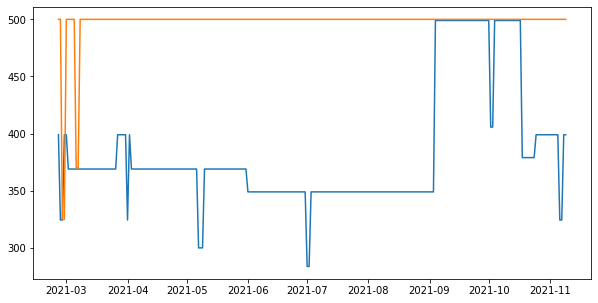

In [ ]:
i = 151
print(df_pairs_follows.product_group_id.iloc[i], df_pairs_follows.company_1.iloc[i], df_pairs_follows.company_2.iloc[i])
plt.plot(df_pairs_follows.x1_aligned.iloc[i])
plt.plot(df_pairs_follows.x2_aligned.iloc[i]);

In [ ]:
high_correlation = [0, 1, 2, 3, 4, 5, 14, 18, 19, 20, 22, 30, 35, 36, 46, 47, 48, 50, 60, 62, 63, 64, 78, 94, 95, 106, 136, 152]
i = high_correlation[12]
x1 = df_pairs_follows.x1_aligned.iloc[i]
x2 = df_pairs_follows.x2_aligned.iloc[i]

NameError: ignored

245 Media Markt Worten


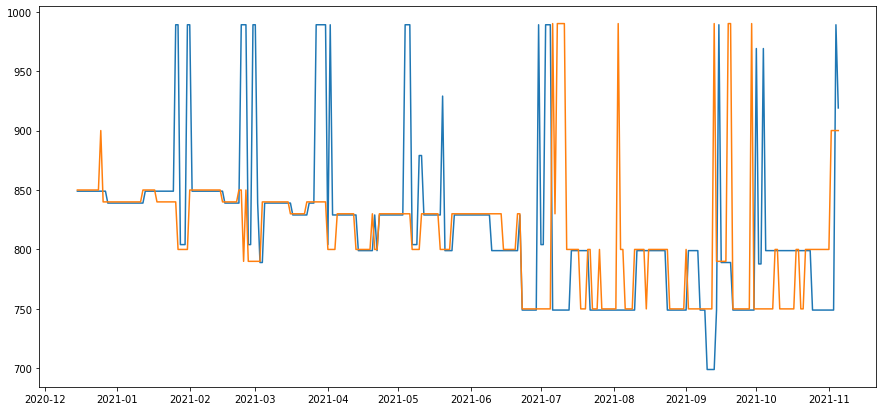

In [ ]:
print(df_pairs_follows.product_group_id.iloc[i], df_pairs_follows.company_1.iloc[i], df_pairs_follows.company_2.iloc[i])
plt.plot(df_pairs_follows.x1_aligned.iloc[i])
plt.plot(df_pairs_follows.x2_aligned.iloc[i]);

In [ ]:
alignment = dtw(x1, x2, keep_internals=True)
#alignment.matrix
dir(alignment)
alignment.costMatrix
alignment.distance

1572.7800000000034

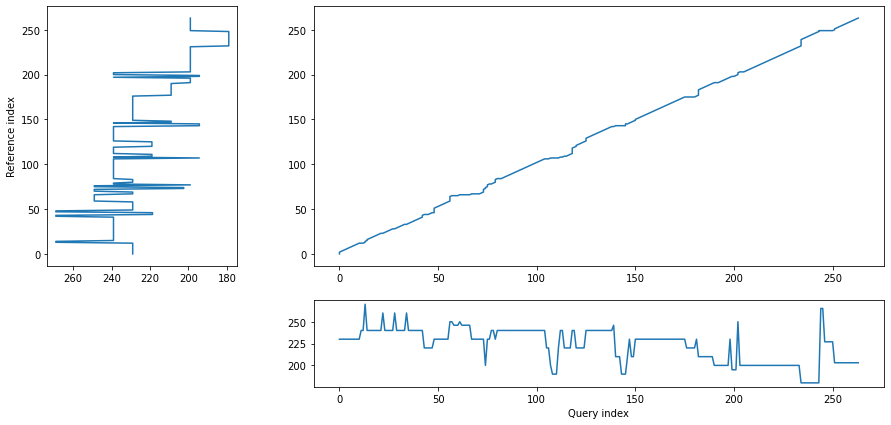

In [ ]:
alignment.plot(type="threeway")

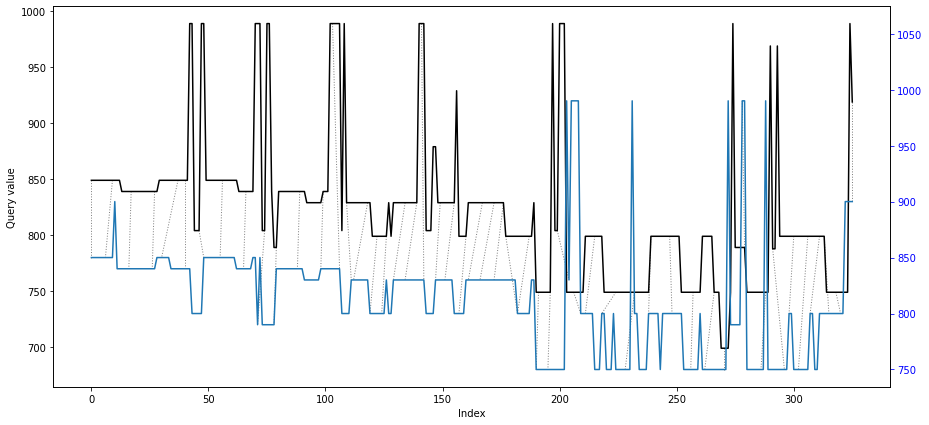

In [ ]:
#dtw(x1[:100], x2[:100], keep_internals=True, window_args={'window_size': 100}, window_type = "sakoechiba", step_pattern=rabinerJuangStepPattern(6, "c")).plot(type="twoway",offset=-100)
#dtw(x1[:100], x2[:100], keep_internals=True, window_args={'window_size': 10}, window_type = "sakoechiba").plot(type="twoway",offset=-70)
dtw(x1, x2, keep_internals=True, window_args={'window_size': 7}, window_type = "sakoechiba").plot(type="twoway",offset=-70)

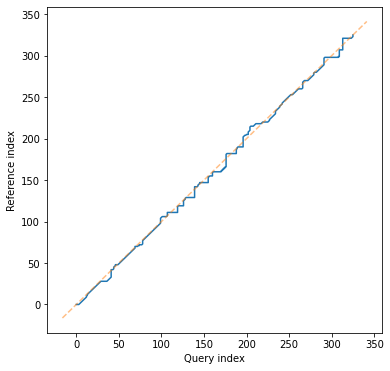

In [ ]:
p = dtw(x1, x2, keep_internals=True, window_type="sakoechiba", window_args={'window_size': 10}).plot()
p.plot(p.get_xlim(), p.get_ylim(), linestyle='dashed', alpha = 0.5)

In [ ]:
Dynamic Time Warping
https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd
https://dynamictimewarping.github.io/
https://colab.research.google.com/drive/1-fbhBlKRrEG8jkqoBAWOAzWaOarDQcDp#scrollTo=z-LgRXsC2jW9
https://medium.com/walmartglobaltech/time-series-similarity-using-dynamic-time-warping-explained-9d09119e48ec

Artigo de desvalorização dos endpoints
https://core.ac.uk/download/pdf/78275924.pdf

In [ ]:
1 3 5 6 7 14 18 27 2

23 Vodafone Media Markt


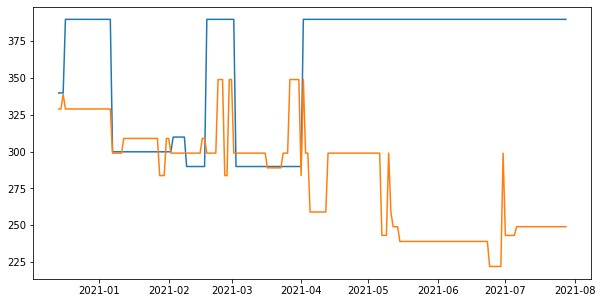

In [ ]:
i = 49
print(df_pairs.product_group_id.iloc[i], df_pairs.company_1.iloc[i], df_pairs.company_2.iloc[i])
plt.plot(df_pairs.x1_aligned.iloc[i])
plt.plot(df_pairs.x2_aligned.iloc[i]);

In [ ]:
product_group_id = 
df_corr_flt = df_corr[df_corr.product_group_id == 1]

i = 300
print(df_corr_flt.product_group_id.iloc[i], df_corr_flt.company_1.iloc[i], df_corr_flt.company_2.iloc[i])

print(len(df_corr_flt.x1_slide_corr.iloc[i]))
fig, ax = plt.subplots(2, 1)
ax[0].plot(df_corr_flt.x1_slide.iloc[i])
ax[0].plot(df_corr_flt.x2_slide.iloc[i])

ax[1].plot(df_corr_flt.x1_slide_corr.iloc[i])
ax[1].plot(df_corr_flt.x2_slide_corr.iloc[i])

IndexError: ignored